In [1]:
%matplotlib widget
import atomap.api as am
import numpy as np
import atomap.dummy_data as dummy_data
import cv2
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.neighbors import KDTree

In [2]:
import hyperspy.api as hs
your_image = hs.load(r"E:\Data CrCoNiSi0.3\TEM picture\2-deforming\ballistic\complex board\ballistic -20 mm\2222\STEM HAAD Extracted ROI.tif")
s = your_image
s_peaks = am.get_feature_separation(s, separation_range=(2, 20), show_progressbar=True)
s_peaks.plot()

  0%|          | 0/18 [00:00<?, ?it/s]

[########################################] | 100% Completed |  0.1s


In [3]:
import hyperspy.api as hs
s_peaks = am.get_feature_separation(s, separation_range=(2, 20), show_progressbar=True)
atom_positions = am.get_atom_positions(s, separation= 5)
sublattice = am.Sublattice(atom_positions, image= your_image)
sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass()
sublattice.refine_atom_positions_using_2d_gaussian()


  0%|          | 0/18 [00:00<?, ?it/s]

[########################################] | 100% Completed |  0.1s


Center of mass:   0%|          | 0/1183 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/1183 [00:00<?, ?it/s]

In [4]:
sublattice.get_position_history().plot()
sublattice2 = sublattice

In [5]:
sublattice.construct_zone_axes(atom_plane_tolerance= 0.5 ,nearest_neighbors=25)
sublattice.plot_planes()

In [6]:
zone_vec_list = sublattice.zones_axis_average_distances[0:3]
atom_planes = sublattice.atom_planes_by_zone_vector[zone_vec_list[0]]
atom_positions_cpp = []
atom_positions_cpp_array = []
for i, plane in enumerate(atom_planes):
    x_positions = plane.x_position  # 取得该平面上所有原子的 x 坐标列表
    y_positions = plane.y_position  # 取得该平面上所有原子的 y 坐标列表
    for x, y in zip(x_positions, y_positions):
        atom_positions_cpp.append((x, y, i))
        atom_positions_cpp_array.append((x , y))
df_cpp = pd.DataFrame(atom_positions_cpp, columns=['x_position', 'y_position', 'plane_index'])
df_cpp

x_position  y_position  plane_index
0     272.919604    9.950252            0
1     274.083305   17.658436            0
2     274.994085   25.408040            0
3     276.198371   33.216367            0
4     277.398968   41.079807            0
...          ...         ...          ...
1176    7.051741  240.227802           37
1177    8.126510  248.331093           37
1178    9.556537  256.011319           37
1179   10.809180  264.003035           37
1180   12.121664  271.548714           37

[1181 rows x 3 columns]

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans


# 找到每个点的邻居并计算向量
def find_neighbors_within_radius(atom_positions_cpp_array, radius=50):
    coordinates = np.array(atom_positions_cpp_array)
    tree = KDTree(coordinates, leaf_size=30)
    indices_within_radius = tree.query_radius(coordinates, r=radius)
    
    data = {
        'self_x': [],
        'self_y': [],
        'neighbor1_x': [],
        'neighbor1_y': [],
        'neighbor2_x': [],
        'neighbor2_y': [],
        'neighbor3_x': [],
        'neighbor3_y': [],
        'neighbor4_x': [],
        'neighbor4_y': [],
        'neighbor5_x': [],
        'neighbor5_y': [],
        'neighbor6_x': [],
        'neighbor6_y': []
    }
    
    for i in range(len(coordinates)):
        data['self_x'].append(coordinates[i, 0])
        data['self_y'].append(coordinates[i, 1])
        
        neighbors = indices_within_radius[i]
        neighbors = neighbors[neighbors != i]
        
        for j in range(1, 7):
            if j <= len(neighbors):
                neighbor_index = neighbors[j-1]
                data[f'neighbor{j}_x'].append(coordinates[neighbor_index, 0])
                data[f'neighbor{j}_y'].append(coordinates[neighbor_index, 1])
            else:
                data[f'neighbor{j}_x'].append(np.nan)
                data[f'neighbor{j}_y'].append(np.nan)
    
    df = pd.DataFrame(data)
    return df

def filter_rows_without_nan(df):
    df['contains_nan'] = df.isnull().any(axis=1)
    return df[~df['contains_nan']].drop(columns='contains_nan')

def calculate_vectors(df):
    vectors_data = {
        'self_x': df['self_x'],
        'self_y': df['self_y'],
    }
    
    for i in range(1, 7):
        vectors_data[f'vec_{i}_x'] = df[f'neighbor{i}_x'] - df['self_x']
        vectors_data[f'vec_{i}_y'] = df[f'neighbor{i}_y'] - df['self_y']
    
    vectors_df = pd.DataFrame(vectors_data)
    vectors_df = vectors_df[(vectors_df.filter(like='vec_').abs() > 1e-6).any(axis=1)]
    
    return vectors_df

# 逆时针排序函数
def angle_from_x_axis(vec):
    return np.arctan2(vec[1], vec[0])

def sort_vectors_counterclockwise(vectors):
    vector_array = np.array(vectors).reshape(-1, 2)
    angles = np.array([angle_from_x_axis(vec) for vec in vector_array])
    vector_df = pd.DataFrame(vector_array, columns=['x', 'y'])
    vector_df['angle'] = angles
    vector_df_sorted = vector_df.sort_values(by='angle', ascending=True).reset_index(drop=True)
    sorted_vectors = vector_df_sorted[['x', 'y']].values.flatten().tolist()
    return sorted_vectors

def sort_vectors_in_dataframe(row):
    vectors = row[['vec_1_x', 'vec_1_y', 'vec_2_x', 'vec_2_y', 'vec_3_x', 'vec_3_y', 
                   'vec_4_x', 'vec_4_y', 'vec_5_x', 'vec_5_y', 'vec_6_x', 'vec_6_y']].tolist()
    sorted_vectors = sort_vectors_counterclockwise(vectors)
    return pd.Series(sorted_vectors, index=['vec_1_x', 'vec_1_y', 'vec_2_x', 'vec_2_y', 'vec_3_x', 'vec_3_y', 
                                            'vec_4_x', 'vec_4_y', 'vec_5_x', 'vec_5_y', 'vec_6_x', 'vec_6_y'])

# 聚类和可视化函数
def cluster_vectors(vectors, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)
    labels = kmeans.labels_
    vectors_labeled = pd.DataFrame(vectors, columns=['x', 'y'])
    vectors_labeled['label'] = labels
    mean_vectors = vectors_labeled.groupby('label').mean().reset_index()
    mean_vectors.columns = ['label', 'mean_x', 'mean_y']
    label_counts = vectors_labeled['label'].value_counts().reset_index()
    label_counts.columns = ['label', 'count']
    cluster_info = pd.merge(mean_vectors, label_counts, on='label')
    total_count = vectors_labeled.shape[0]
    cluster_info['proportion'] = cluster_info['count'] / total_count
    return cluster_info

def visualize_clusters(vectors, cluster_info):
    kmeans = KMeans(n_clusters=len(cluster_info), random_state=0).fit(vectors)
    labels = kmeans.labels_
    vectors_labeled = pd.DataFrame(vectors, columns=['x', 'y'])
    vectors_labeled['label'] = labels
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(cluster_info['proportion'])
    
    for i, label in enumerate(cluster_info['label']):
        clustered_points = vectors_labeled[vectors_labeled['label'] == label]
        plt.scatter(clustered_points['x'], clustered_points['y'], c=[colors[i]], label=f'Cluster {label}', s=10)
    
    plt.colorbar()
    plt.title('2D Vector Clustering with Proportional Colors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()



In [118]:
def plot_vectors(radius):
    # 使用函数并获取结果 DataFrame
    df = find_neighbors_within_radius(df_cpp[['x_position', 'y_position']].values, radius=radius)
    
    # 过滤掉包含 NaN 的行
    df_t2 = filter_rows_without_nan(df)
    
    # 计算向量并获取结果 DataFrame
    vectors_df = calculate_vectors(df_t2)
    
    # 绘制向量散点图
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    plt.figure(figsize=(8, 8))

    for i in range(1, 7):
        plt.scatter(vectors_df[f'vec_{i}_x'], vectors_df[f'vec_{i}_y'], color=colors[i-1], label=f'vec_{i}')

    plt.xlabel('Vector X')
    plt.ylabel('Vector Y')
    plt.title(f'Scatter Plot of Vectors (Radius = {radius})')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(plot_vectors, radius=widgets.FloatSlider(value=30, min=1, max=50, step=0.5))

interactive(children=(FloatSlider(value=30.0, description='radius', max=50.0, min=1.0, step=0.5), Output()), _…

<function __main__.plot_vectors(radius)>

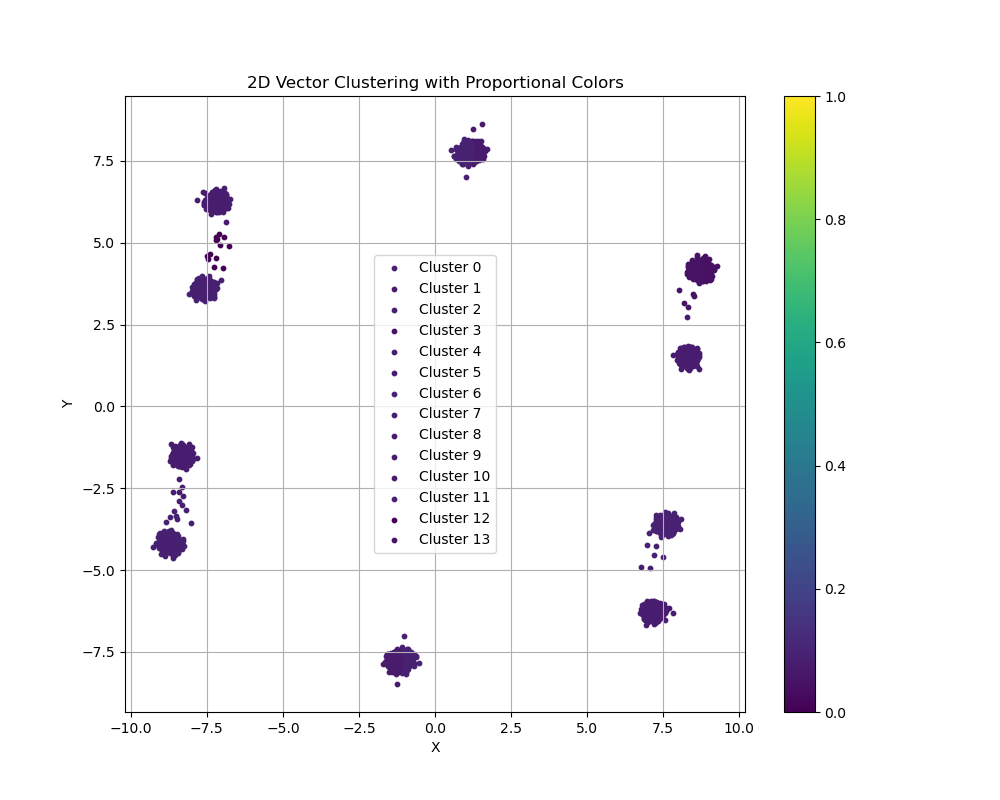

In [119]:
# 主函数
def main(df_cpp, radius= 10.5, num_clusters= 10):
    df = find_neighbors_within_radius(df_cpp[['x_position', 'y_position']].values, radius=radius)
    df_filtered = filter_rows_without_nan(df)
    vectors_df = calculate_vectors(df_filtered)
    sorted_vectors_df = vectors_df.apply(sort_vectors_in_dataframe, axis=1)
    result_df = pd.concat([vectors_df[['self_x', 'self_y']], sorted_vectors_df], axis=1)
    vector_columns = [col for col in result_df.columns if 'vec_' in col]
    vectors_combined = result_df[vector_columns].values.reshape(-1, 2)
    cluster_info = cluster_vectors(vectors_combined, num_clusters=num_clusters)
    visualize_clusters(vectors_combined, cluster_info)
    return result_df, cluster_info

# 运行主函数
result_df, cluster_info = main(df_cpp, radius=11.5, num_clusters=14)

In [120]:
cluster_info['length'] = np.sqrt(cluster_info['mean_x']**2 + cluster_info['mean_y']**2)
cluster_info

label    mean_x    mean_y  count  proportion    length
0       0 -1.032670 -7.771453    586    0.093550  7.839764
1       1  1.299831  7.780961    460    0.073436  7.888784
2       2 -7.573862  3.606878    547    0.087324  8.388859
3       3  8.861980  4.180998    260    0.041507  9.798747
4       4  7.178283 -6.246022    468    0.074713  9.515279
5       5 -8.337371 -1.530488    488    0.077905  8.476683
6       6  7.572579 -3.612655    576    0.091954  8.390187
7       7 -8.714671 -4.154171    556    0.088761  9.654151
8       8 -7.180272  6.249829    484    0.077267  9.519278
9       9  8.335139  1.523865    467    0.074553  8.473294
10     10 -1.301187 -7.775855    458    0.073116  7.883972
11     11  1.029290  7.771175    584    0.093231  7.839043
12     12 -7.169901  4.804655     13    0.002075  8.630885
13     13  8.588792  4.144888    317    0.050607  9.536637

In [105]:
st_vec_1 = cluster_info.iloc[0,1:3]
st_vec_1 = st_vec_1.to_numpy()
st_vec_1

array([-1.03266959, -7.77145348])

In [110]:
import numpy as np

def rotate_vector(vec, angle_degrees):
    """
    Rotates a 2D vector counterclockwise by a given angle.

    Parameters:
    vec (array-like): The 2D vector to be rotated.
    angle_degrees (float): The angle in degrees by which to rotate the vector.

    Returns:
    np.ndarray: The rotated 2D vector.
    """
    # Convert angle to radians
    angle_radians = np.radians(angle_degrees)

    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])

    # Rotate the vector
    rotated_vec = rotation_matrix @ vec

    return rotated_vec

# 示例向量和旋转角度
st_vec_1 = np.array([-1.02981834, -7.76059475])
angle = 70.52
st_vec_2 = rotate_vector (st_vec_1, angle)
st_vec_3 =  rotate_vector (st_vec_1, 180)
st_vec_4 =  rotate_vector (st_vec_2, 180)

# 创建 DataFrame
st_df = pd.DataFrame({
    'mean_x': [st_vec_1[0], st_vec_2[0], st_vec_3[0], st_vec_4[0]],
    'mean_y': [st_vec_1[1], st_vec_2[1], st_vec_3[1], st_vec_4[1]]
})


     mean_x    mean_y
0 -1.029818 -7.760595
1  6.972941 -3.558855
2  1.029818  7.760595
3 -6.972941  3.558855


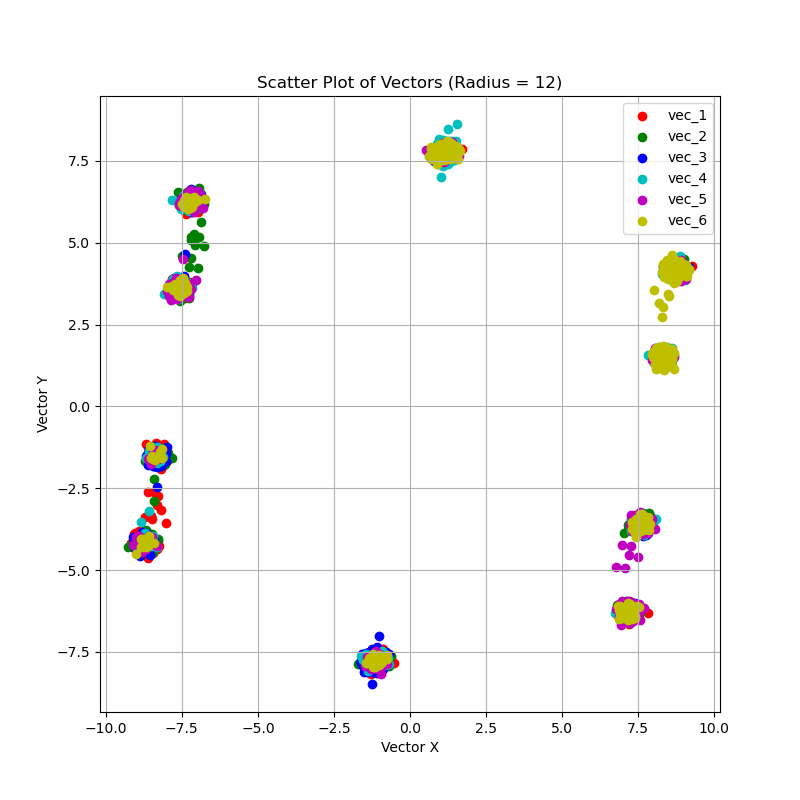

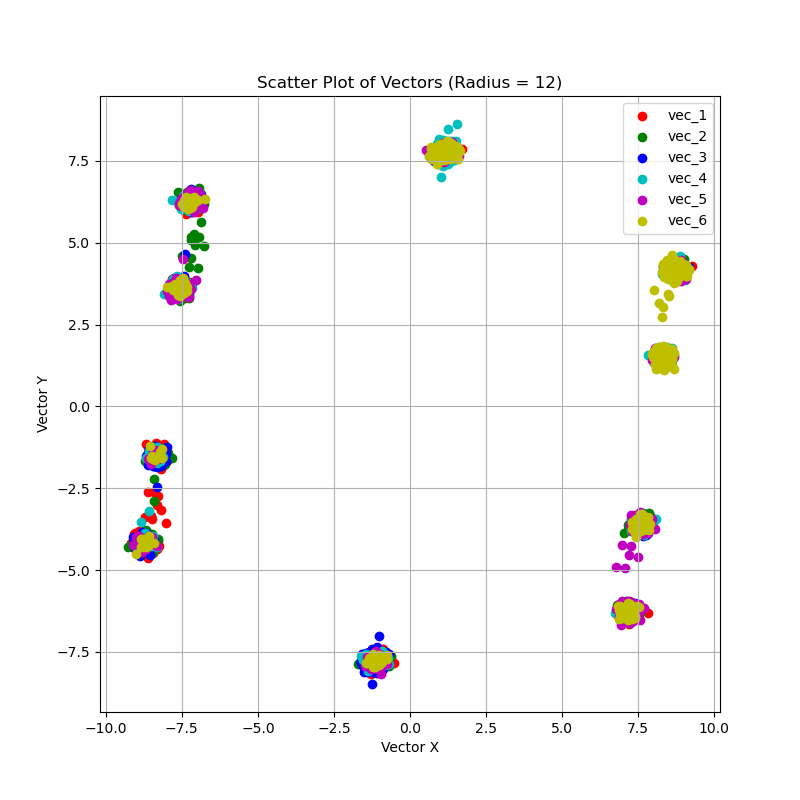

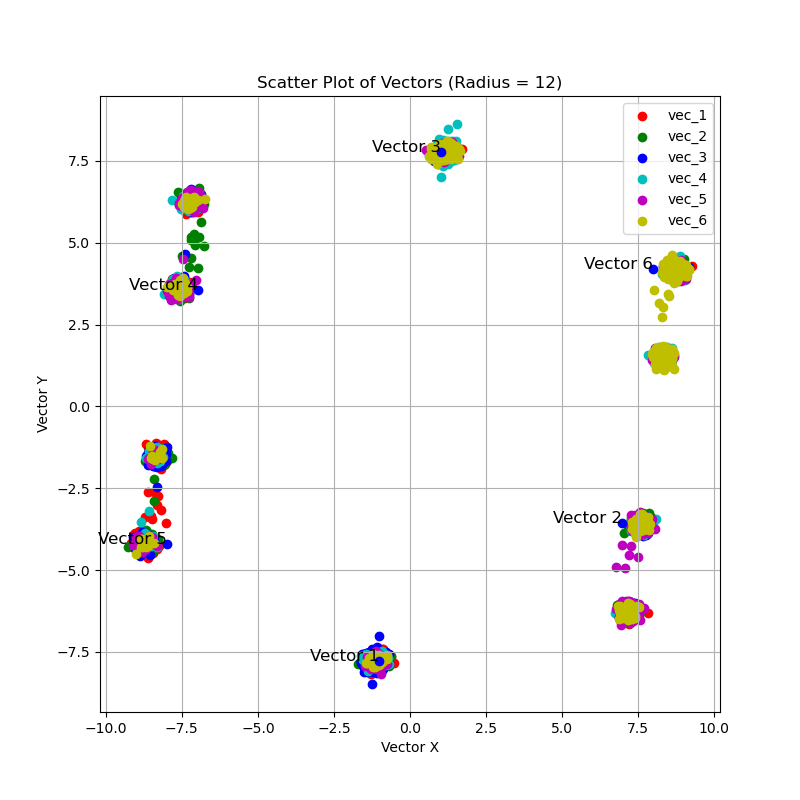

In [124]:
plot_vectors (12)
def add_points_to_existing_plot(points):
    ax = plt.gca()
    for i, (x, y) in enumerate(points):
        ax.scatter(x, y, color='blue')
        ax.text(x, y, f'Vector {i+1}', fontsize=12, ha='right')
    plt.draw()

# 初始向量
st_vec_1 = np.array([-1.02981834, -7.76059475])
angle = 70.52
st_vec_2 = rotate_vector(st_vec_1, angle)
st_vec_3 = rotate_vector(st_vec_1, 180)
st_vec_4 = rotate_vector(st_vec_2, 180)
st_vec_5 = st_vec_1 + st_vec_4
st_vec_6 = st_vec_2 + st_vec_3
# 生成新点的列表
new_points = [st_vec_1, st_vec_2, st_vec_3, st_vec_4, st_vec_5,st_vec_6]

# 调用 plot_vectors 函数绘制原始图层
plot_vectors(12)

# 添加新点到现有图层
add_points_to_existing_plot(new_points)

# 显示最终图表
plt.show()

In [133]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
df = result_df
def find_closest_vectors(df, target_vector):
    closest_vectors = []
    distances = []
    
    for index, row in df.iterrows():
        vectors = np.array([
            [row['vec_1_x'], row['vec_1_y']],
            [row['vec_2_x'], row['vec_2_y']],
            [row['vec_3_x'], row['vec_3_y']],
            [row['vec_4_x'], row['vec_4_y']],
            [row['vec_5_x'], row['vec_5_y']],
            [row['vec_6_x'], row['vec_6_y']]
        ])
        
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(vectors)
        dist, idx = nn.kneighbors([target_vector])
        
        closest_vectors.append(vectors[idx[0][0]])
        distances.append(dist[0][0])
    
    # 将最近向量的信息添加到 DataFrame 中
    df['closest_vector_x'] = [vec[0] for vec in closest_vectors]
    df['closest_vector_y'] = [vec[1] for vec in closest_vectors]
    df['min_distance'] = distances
    
    # 计算与目标向量的差向量
    df['diff_x'] = df['closest_vector_x'] - target_vector[0]
    df['diff_y'] = df['closest_vector_y'] - target_vector[1]
    
    # 选择需要的列进行显示
    result_df3 = df[['self_x', 'self_y', 'closest_vector_x', 'closest_vector_y', 'min_distance', 'diff_x', 'diff_y']]
    
    return result_df3
target_vectors = [st_vec_1, st_vec_2, st_vec_3, st_vec_4, st_vec_5,st_vec_6]
strain_all = pd.DataFrame()
for i, target_vector in enumerate(target_vectors, start=1):
    result_df3 = find_closest_vectors(df, target_vector)
    result_df3 = result_df3.rename(columns={
        'min_distance': f'min_distance_{i}',
        'diff_x': f'diff_x_{i}',
        'diff_y': f'diff_y_{i}'
    })
    
    if strain_all.empty:
        strain_all = result_df3[['self_x', 'self_y', f'min_distance_{i}', f'diff_x_{i}', f'diff_y_{i}']]
    else:
        strain_all = pd.merge(strain_all, result_df3[['self_x', 'self_y', f'min_distance_{i}', f'diff_x_{i}', f'diff_y_{i}']], on=['self_x', 'self_y'], how='left')
strain_all['distance_sum'] = strain_all[[f'min_distance_{i}' for i in range(1, 5)]].sum(axis=1)
strain_sum = strain_all[['self_x', 'self_y', 'distance_sum']]


self_x      self_y  distance_sum
0     265.321606   13.619361      1.787816
1     266.476489   21.278374      1.584455
2     267.364580   28.934280      1.533550
3     268.689283   36.713245      1.795927
4     257.775127   17.020702      1.738243
...          ...         ...           ...
1039   14.240958  235.064646      3.362569
1040   15.481885  242.458708      4.193608
1041   16.739243  250.936563      3.945079
1042   17.972891  258.900232      3.987135
1043   18.985894  265.902309      4.624453

[1044 rows x 3 columns]

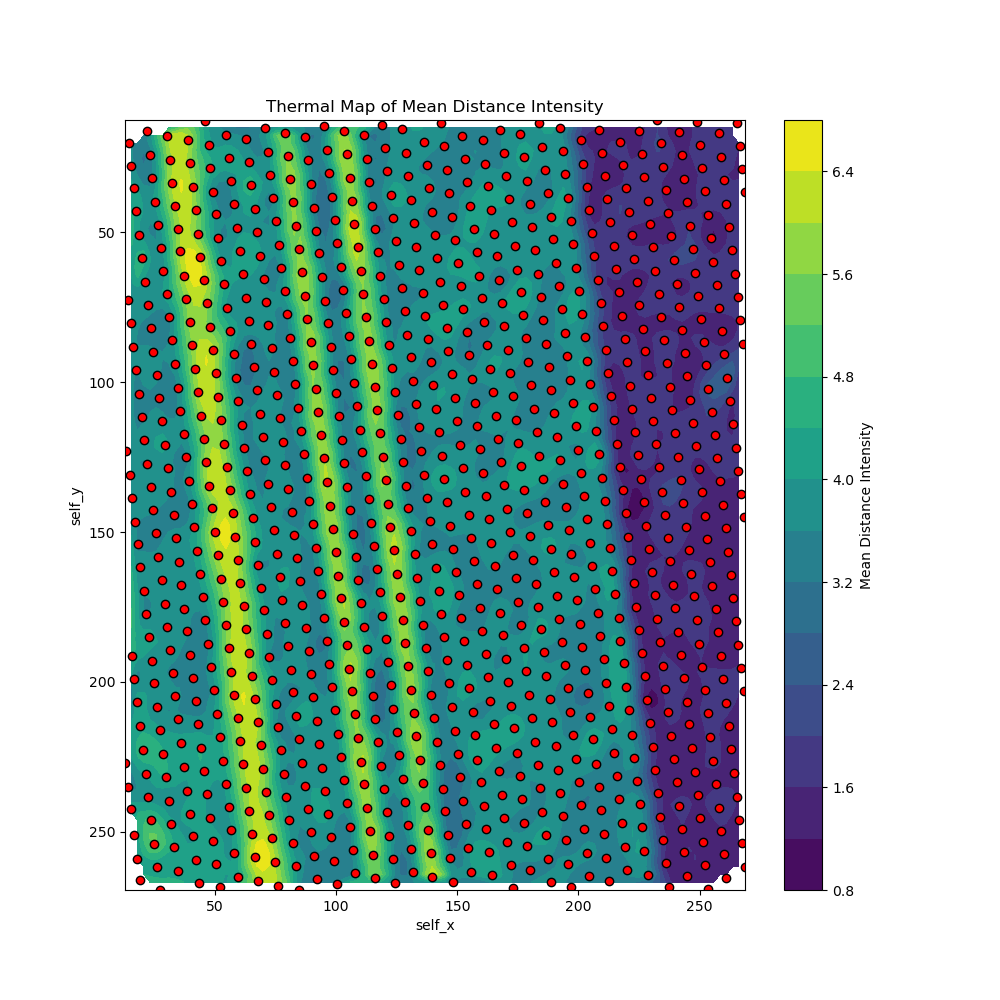

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_thermal_map(x, y, z):
    """
    绘制热图
    :param x: x 坐标的数组
    :param y: y 坐标的数组
    :param z: z 值的数组
    """
    # 定义网格
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # 插值
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # 绘制热图
    plt.figure(figsize=(10, 10))
    plt.contourf(xi, yi, zi, levels=15, cmap='viridis')
    plt.colorbar(label='Mean Distance Intensity')
    plt.scatter(x, y, c='red', edgecolor='k')
    plt.xlabel('self_x')
    plt.ylabel('self_y')
    plt.title('Thermal Map of Mean Distance Intensity')
    plt.gca().invert_yaxis()
    plt.show()
plot_thermal_map(strain_sum['self_x'] , strain_sum ['self_y'] ,strain_sum ['distance_sum'])

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipywidgets as widgets
from ipywidgets import interact

# 加载原子及其向量数据
df = result_df

# 加载标签数据
def find_label(vector, cluster_info, tol= 1.9):
    """
    根据给定向量查找其标签。
    
    :param vector: 向量 (x, y)
    :param cluster_info: 包含 mean_x, mean_y 和 label 的 DataFrame
    :param tol: 查找标签的容差
    :return: 标签
    """
    for _, row in cluster_info.iterrows():
        mean_x, mean_y, label = row['mean_x'], row['mean_y'], row['label']
        if np.allclose(vector, [mean_x, mean_y], atol=tol):
            return label
    return np.nan

def update_plot(tol):
    # 为每个原子的6个向量查找标签
    label_data = {}
    label_data['self_x'] = df['self_x']
    label_data['self_y'] = df['self_y']
    for i in range(1, 7):
        label_col = f'label_vec{i}'
        label_data[label_col] = df.apply(lambda row: find_label([row[f'vec_{i}_x'], row[f'vec_{i}_y']], cluster_info, tol), axis=1)

    # 创建结果 DataFrame
    label_df = pd.DataFrame(label_data)

    # 计算不同排列组合的数量
    label_combinations = label_df[['label_vec1', 'label_vec2', 'label_vec3', 'label_vec4', 'label_vec5', 'label_vec6']].apply(lambda row: tuple(row), axis=1)
    combination_counts = label_combinations.value_counts()

    # 取数量前四多的排列组合
    top_combinations = combination_counts.head(4)

    # 创建一个字典，给每种排列组合分配颜色
    colors = ['red', 'green', 'blue', 'orange']
    combination_color_map = {comb: color for comb, color in zip(top_combinations.index, colors)}

    # 给每个原子的排列组合分配颜色
    label_df['color'] = label_combinations.map(combination_color_map)

    # 加载背景图像
    background_image = sublattice.image  # 替换为实际路径

    # 绘制点散图
    fig, ax = plt.subplots(figsize=(10, 8))


    # 显示灰度图像
    ax.imshow(background_image, cmap='gray')

    # 绘制点散图
    for comb, color in combination_color_map.items():
        subset = label_df[label_combinations == comb]
        ax.scatter(subset['self_x'], subset['self_y'], c=color, label=f'{comb}', s=10)

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Scatter Plot of Atoms with Top 4 Label Combinations')
    plt.show()

# 创建交互滑块
interact(update_plot, tol=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description='Tolerance'))


interactive(children=(FloatSlider(value=5.0, description='Tolerance', max=10.0), Output()), _dom_classes=('wid…

<function __main__.update_plot(tol)>

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_polar_bars(df):
    """
    Plots a polar bar plot from a DataFrame with 'mean_x', 'mean_y', 'proportion', and 'label' columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame with the required columns.
    """
    # Calculate angles
    angles = np.arctan2(df['mean_y'], df['mean_x'])

    # Create the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Bar plot
    bars = ax.bar(angles, df['proportion'], width=0.1, edgecolor='w', linewidth=0.9)

    # Set color for each bar
    for bar, label in zip(bars, df['label']):
        bar.set_facecolor(plt.cm.tab10(label / 10.0))

    # Set labels
    ax.set_title('Pole Plot of Labels 0-9')
    plt.show()

##排序cluster info
result_df2 = result_df
cluster_info_sorted = {}

# 计算角度（以度为单位）
cluster_info['angle'] = np.degrees(np.arctan2(cluster_info['mean_y'], cluster_info['mean_x']))

# 将角度范围调整为 0 到 360 度
cluster_info['angle'] = cluster_info['angle'] % 360

# 根据角度排序
cluster_info_sorted = cluster_info.sort_values(by='angle').reset_index(drop=True)

# 显示排序后的 DataFrame
vec = cluster_info_sorted[['mean_x','mean_y' ]].iloc[3]
target_vector = vec.to_numpy()

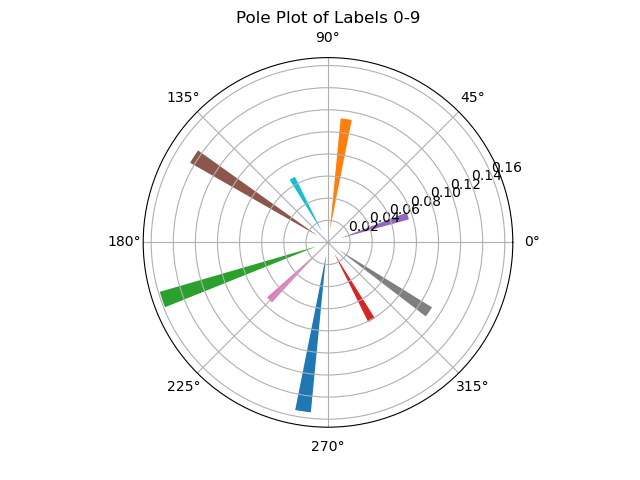

In [77]:
plot_polar_bars(cluster_info)

In [78]:
##找最近的vec 算距離
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors


df = result_df2

# 目标向量

# 为每行查找最接近的向量
closest_vectors = []
distances = []
for index, row in df.iterrows():
    vectors = np.array([
        [row['vec_1_x'], row['vec_1_y']],
        [row['vec_2_x'], row['vec_2_y']],
        [row['vec_3_x'], row['vec_3_y']],
        [row['vec_4_x'], row['vec_4_y']],
        [row['vec_5_x'], row['vec_5_y']],
        [row['vec_6_x'], row['vec_6_y']]
    ])
    
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(vectors)
    dist, idx = nn.kneighbors([target_vector])
    
    closest_vectors.append(vectors[idx[0][0]])
    distances.append(dist[0][0])

# 将最近向量的信息添加到 DataFrame 中
df['closest_vector_x'] = [vec[0] for vec in closest_vectors]
df['closest_vector_y'] = [vec[1] for vec in closest_vectors]
df['min_distance'] = distances

# 计算与目标向量的差向量
df['diff_x'] = df['closest_vector_x'] - target_vector[0]
df['diff_y'] = df['closest_vector_y'] - target_vector[1]

# 选择需要的列进行显示
result_df3 = df[['self_x', 'self_y', 'closest_vector_x', 'closest_vector_y', 'min_distance', 'diff_x', 'diff_y']]

strain_vec1 = {}
strain_vec1= { 'self_x': result_df3[ 'self_x'],
             'self_y': result_df3[ 'self_y'],
             'min_distance': result_df3['min_distance'],             
}
strain_vec1 = pd.DataFrame(strain_vec1)

In [79]:
result_df3['angle'] = np.degrees(np.arctan2(result_df3['diff_y'], result_df3['diff_x']))
result_df3
strain_vec1 ['angle'] = result_df3['angle']

C:\Users\USER\AppData\Local\Temp\ipykernel_7872\1547054219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df3['angle'] = np.degrees(np.arctan2(result_df3['diff_y'], result_df3['diff_x']))


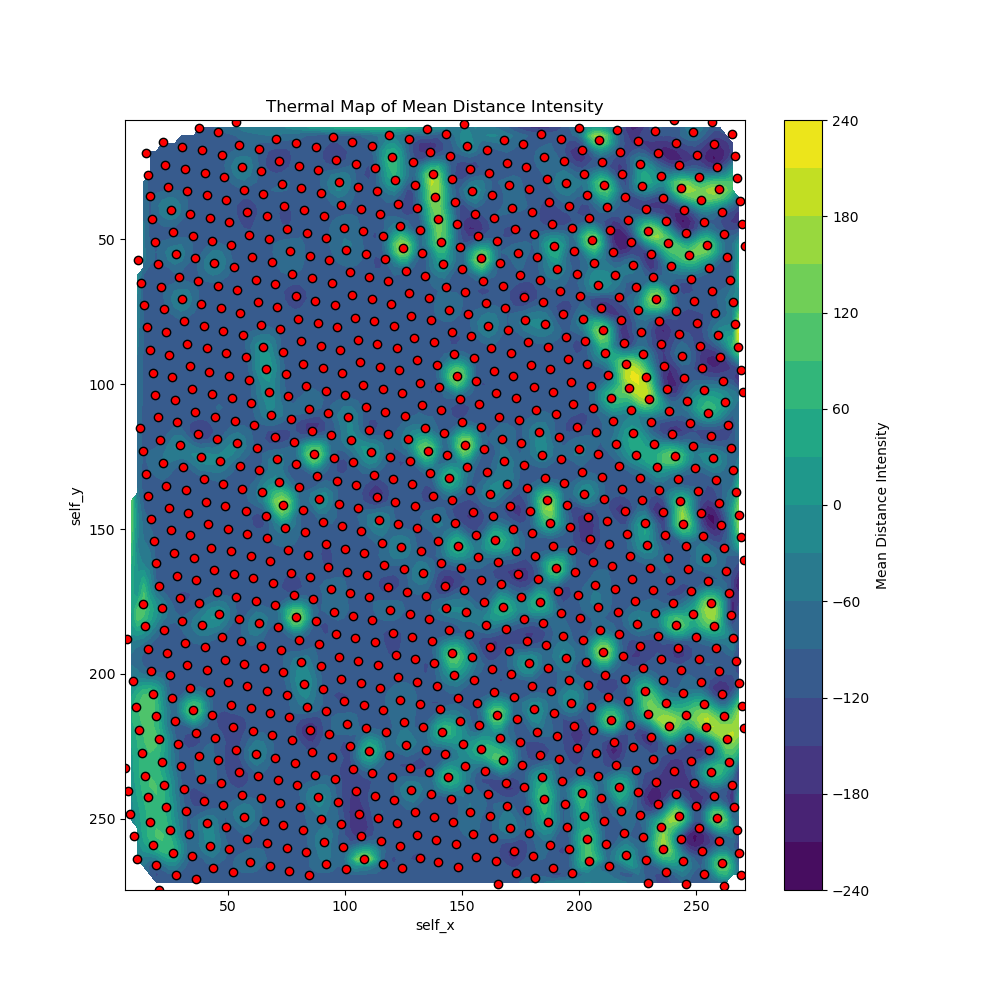

In [80]:
from scipy.interpolate import griddata
x = strain_vec1['self_x']
y = strain_vec1['self_y']
z = strain_vec1['angle']

# 定义网格
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# 插值
zi = griddata((x, y), z, (xi, yi), method='cubic')

# 绘制热图
plt.figure(figsize=(10, 10))
plt.contourf(xi, yi, zi, levels=15, cmap='viridis')
plt.colorbar(label='Mean Distance Intensity')
plt.scatter(x, y, c='red', edgecolor='k')
plt.xlabel('self_x')
plt.ylabel('self_y')
plt.title('Thermal Map of Mean Distance Intensity')
plt.gca().invert_yaxis()
plt.show()

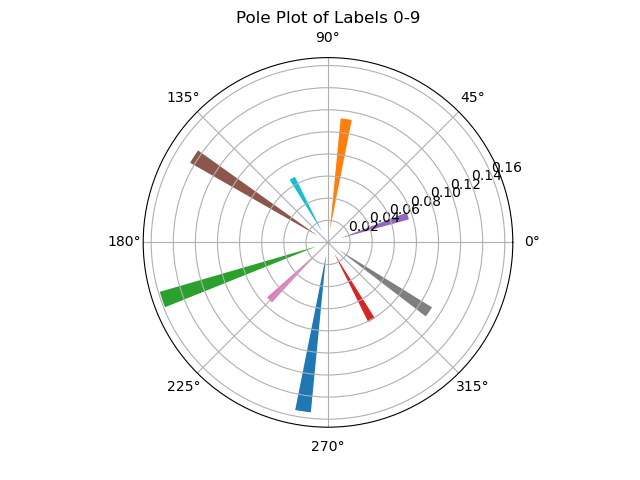

In [81]:
df = cluster_info
# Calculate angles
angles = np.arctan2(df['mean_y'], df['mean_x'])

# Create the polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Bar plot
bars = ax.bar(angles, df['proportion'], width=0.1, edgecolor='w', linewidth=0.9)

# Set color for each bar
for bar, label in zip(bars, df['label']):
    bar.set_facecolor(plt.cm.tab10(label / 10.0))

# Set labels
ax.set_title('Pole Plot of Labels 0-9')
plt.show()

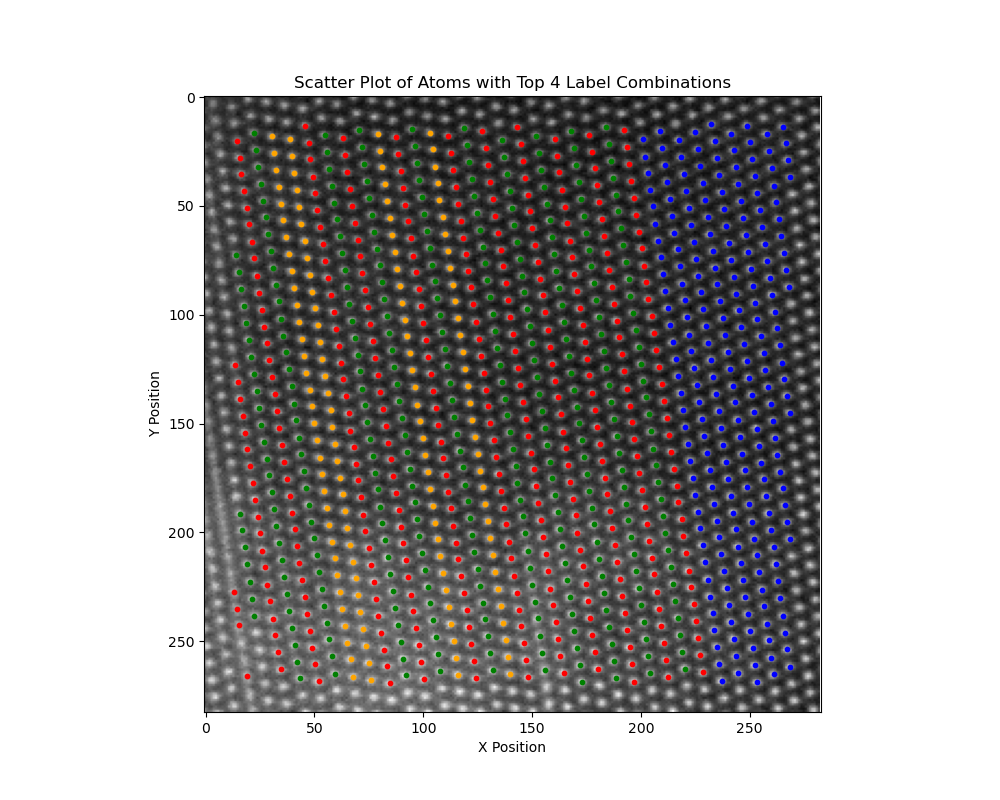

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 加载原子及其向量数据
df = result_df
# 加载标签数据

def find_label(vector, cluster_info, tol= 1.1):
    """
    根据给定向量查找其标签。
    
    :param vector: 向量 (x, y)
    :param cluster_info: 包含 mean_x, mean_y 和 label 的 DataFrame
    :param tol: 查找标签的容差
    :return: 标签
    """
    for _, row in cluster_info.iterrows():
        mean_x, mean_y, label = row['mean_x'], row['mean_y'], row['label']
        if np.allclose(vector, [mean_x, mean_y], atol=tol):
            return label
    return np.nan

# 为每个原子的6个向量查找标签
label_data = {}
label_data['self_x'] = df['self_x']
label_data['self_y'] = df['self_y']
for i in range(1, 7):
    label_col = f'label_vec{i}'
    label_data[label_col] = df.apply(lambda row: find_label([row[f'vec_{i}_x'], row[f'vec_{i}_y']], cluster_info), axis=1)

# 创建结果 DataFrame
label_df = pd.DataFrame(label_data)

# 计算不同排列组合的数量
label_combinations = label_df[['label_vec1', 'label_vec2', 'label_vec3', 'label_vec4', 'label_vec5', 'label_vec6']].apply(lambda row: tuple(row), axis=1)
combination_counts = label_combinations.value_counts()

# 取数量前四多的排列组合
top_combinations = combination_counts.head(4)

# 创建一个字典，给每种排列组合分配颜色
colors = ['red', 'green', 'blue', 'orange']
combination_color_map = {comb: color for comb, color in zip(top_combinations.index, colors)}

# 给每个原子的排列组合分配颜色
label_df['color'] = label_combinations.map(combination_color_map)

# 加载背景图像
background_image = sublattice.image

# 绘制点散图
fig, ax = plt.subplots(figsize=(10, 8))

# 确保背景图像的坐标范围与数据坐标范围一致
extent = [df['self_x'].min(), df['self_x'].max(), df['self_y'].min(), df['self_y'].max()]

# 显示灰度图像
ax.imshow(background_image, cmap='gray')

# 绘制点散图
for comb, color in combination_color_map.items():
    subset = label_df[label_combinations == comb]
    ax.scatter(subset['self_x'], subset['self_y'], c=color, label=f'{comb}', s=10)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Scatter Plot of Atoms with Top 4 Label Combinations')
#ax.legend()
plt.show()



In [16]:
from scipy.spatial import cKDTree
# 构建 KD-Tree
label_coords = label_df[['self_x', 'self_y']].values
cpp_coords = df_cpp[['x_position', 'y_position']].values
tree = cKDTree(label_coords)

# 查找每个点的最近邻居
distances, indices = tree.query(cpp_coords)

# 为 df_cpp 添加颜色列
df_cpp['color'] = label_df['color'].iloc[indices].values

# 显示结果
print(df_cpp)

      x_position  y_position  plane_index color
0     272.919604    9.950252            0  blue
1     274.083305   17.658436            0  blue
2     274.994085   25.408040            0  blue
3     276.198371   33.216367            0  blue
4     277.398968   41.079807            0  blue
...          ...         ...          ...   ...
1176    7.051741  240.227802           37   red
1177    8.126510  248.331093           37   NaN
1178    9.556537  256.011319           37   NaN
1179   10.809180  264.003035           37   red
1180   12.121664  271.548714           37   red

[1181 rows x 4 columns]


In [17]:
# 对每个 plane_index 进行颜色计数和投票
color_counts = df_cpp.groupby(['plane_index', 'color']).size().unstack(fill_value=0)

def get_dominant_color(row):
    # 排除 NaN 计数
    row = row.dropna()
    if len(row) == 0:
        return np.nan
    # 如果 NaN 是最多的颜色，则选择第二多的颜色
    if row.idxmax() == 'NaN':
        row = row[row != row.max()]
    return row.idxmax()

dominant_colors = color_counts.apply(get_dominant_color, axis=1)
dominant_colors.name = 'color'

# 合并颜色计数和投票结果
result_df = color_counts.join(dominant_colors).reset_index()

# 显示结果

In [18]:
import pandas as pd
import numpy as np

# 创建 DataFrame

df = result_df
df['phase'] = None  # 初始化 phase 列

# 标记交替出现两次以上的段落为 HCP
for i in range(1, len(df) - 2):
    if (df.loc[i-1, 'color'] == df.loc[i+1, 'color'] and df.loc[i, 'color'] == df.loc[i+2, 'color'] and 
        df.loc[i-1, 'color'] != df.loc[i, 'color']):
        df.loc[i-1:i+2, 'phase'] = 'HCP'

# 继续标记交替出现多次的段落
i = 1
while i < len(df) - 1:
    if df.loc[i, 'phase'] == 'HCP':
        j = i + 2
        while j < len(df) - 1 and df.loc[j, 'color'] == df.loc[j+1, 'color'] and df.loc[j-1, 'color'] == df.loc[j-2, 'color'] and df.loc[j, 'color'] != df.loc[j-1, 'color']:
            df.loc[j, 'phase'] = 'HCP'
            df.loc[j+1, 'phase'] = 'HCP'
            j += 2
        i = j
    else:
        i += 1

# 找出数量最多和次多的颜色
color_counts = df['color'].value_counts()
most_common_color = color_counts.index[0]
second_most_common_color = color_counts.index[1]

# 标记数量最多和次多的颜色
for i in range(len(df) - 1):
    if df.loc[i, 'color'] == most_common_color and df.loc[i + 1, 'color'] == most_common_color:
        df.loc[i:i + 1, 'phase'] = 'M'
    elif df.loc[i, 'color'] == second_most_common_color and df.loc[i + 1, 'color'] == second_most_common_color:
        df.loc[i:i + 1, 'phase'] = 'T'

# 标记剩余部分为 SF，保留 HCP
df['phase'] = df['phase'].fillna('SF')


# 创建分段标识符
df['segment'] = (df['phase'] != df['phase'].shift()).cumsum()

# 统计每个分段的 phase 和 thickness
segment_info = df.groupby('segment').agg({'phase': 'first', 'plane_index': 'size'}).reset_index()
segment_info.columns = ['segment', 'phase', 'thickness']

# 打印结果
print(segment_info[['phase', 'thickness']])
df['color']

  phase  thickness
0    SF         10
1   HCP         11
2    SF          4
3   HCP          4
4    SF          2
5   HCP          5
6     M          2


0       blue
1       blue
2       blue
3       blue
4       blue
5       blue
6       blue
7       blue
8       blue
9       blue
10       red
11     green
12       red
13     green
14       red
15     green
16       red
17     green
18       red
19     green
20       red
21    orange
22     green
23       red
24    orange
25     green
26       red
27     green
28       red
29    orange
30    orange
31     green
32       red
33     green
34       red
35     green
36       red
37       red
Name: color, dtype: object

In [19]:
df_cpp['phase'] = df_cpp['plane_index'].map(df.set_index('plane_index')['phase'])
df_cpp['color'] = df_cpp['plane_index'].map(df.set_index('plane_index')['color'])

# 打印结果
print(df_cpp)

      x_position  y_position  plane_index color phase
0     272.919604    9.950252            0  blue    SF
1     274.083305   17.658436            0  blue    SF
2     274.994085   25.408040            0  blue    SF
3     276.198371   33.216367            0  blue    SF
4     277.398968   41.079807            0  blue    SF
...          ...         ...          ...   ...   ...
1176    7.051741  240.227802           37   red     M
1177    8.126510  248.331093           37   red     M
1178    9.556537  256.011319           37   red     M
1179   10.809180  264.003035           37   red     M
1180   12.121664  271.548714           37   red     M

[1181 rows x 5 columns]


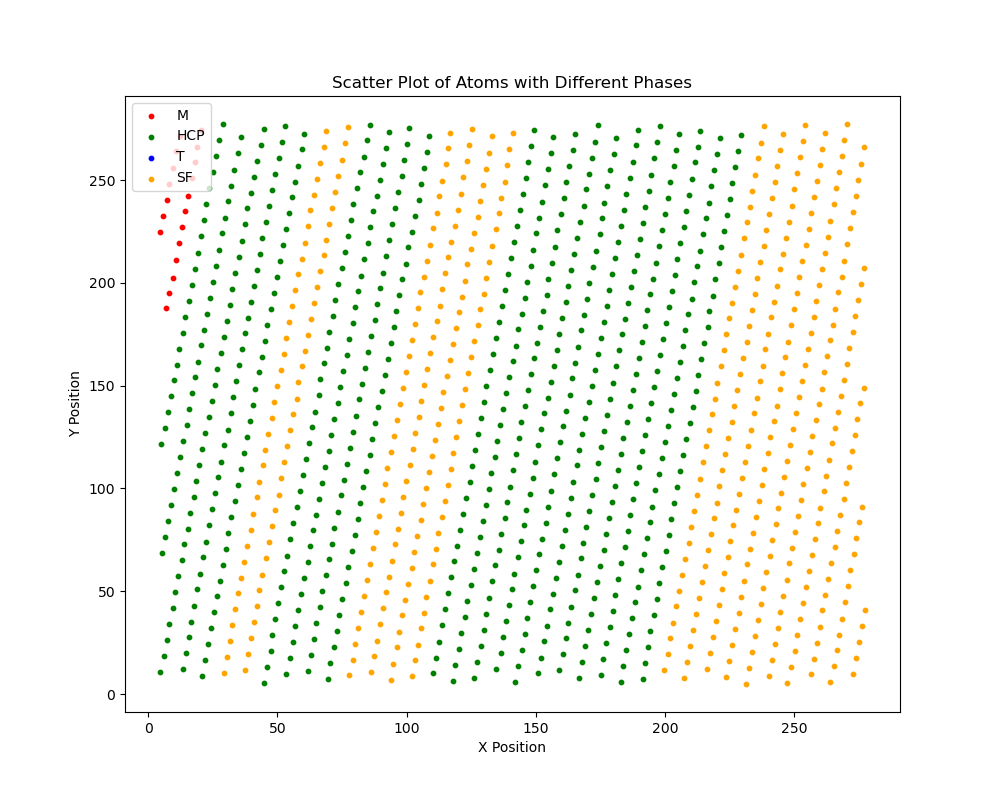

In [20]:
phase_colors = {
    'M': 'red',
    'HCP': 'green',
    'T': 'blue',
    'SF': 'orange'
}

# 绘制点散图
fig, ax = plt.subplots(figsize=(10, 8))

# 为每种 phase 绘制点散图
for phase, color in phase_colors.items():
    subset = df_cpp[df_cpp['phase'] == phase]
    ax.scatter(subset['x_position'], subset['y_position'], c=color, label=f'{phase}', s=10)
# 加载背景图像
background_image = sublattice.image
#ax.imshow(background_image, cmap='gray')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Scatter Plot of Atoms with Different Phases')
ax.legend()
plt.show()

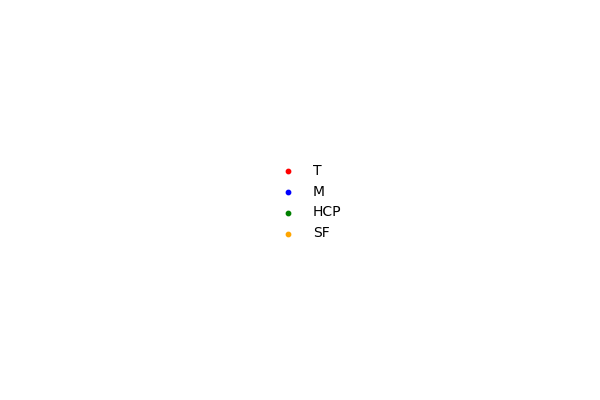

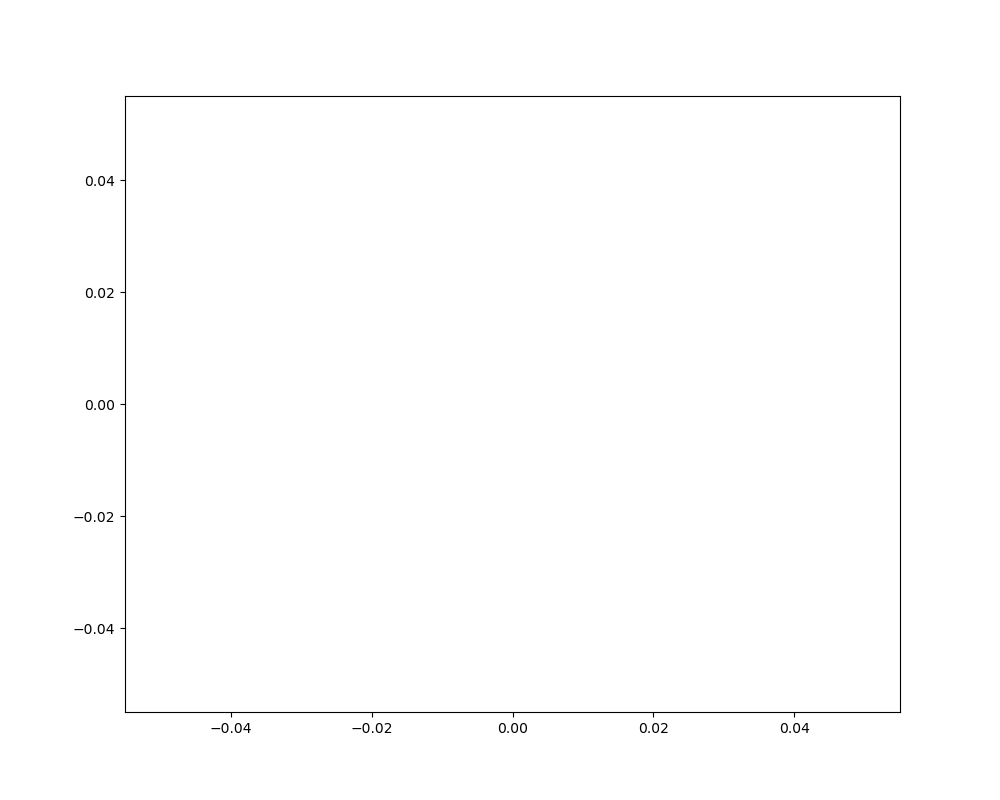

In [21]:
import matplotlib.pyplot as plt

# 现有的 phase 颜色字典
phase_colors = {
    'T': 'red',
    'M': 'blue',
    'HCP': 'green',
    'SF': 'orange'
}

# 创建原始点散图以生成图例
fig, ax = plt.subplots(figsize=(10, 8))

for phase, color in phase_colors.items():
    ax.scatter([], [], c=color, label=f'{phase}', s=10)  # 使用空数据集生成图例项

# 只创建图例的新图像
fig_legend, ax_legend = plt.subplots(figsize=(6, 4))
ax_legend.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
ax_legend.axis('off')  # 关闭轴

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


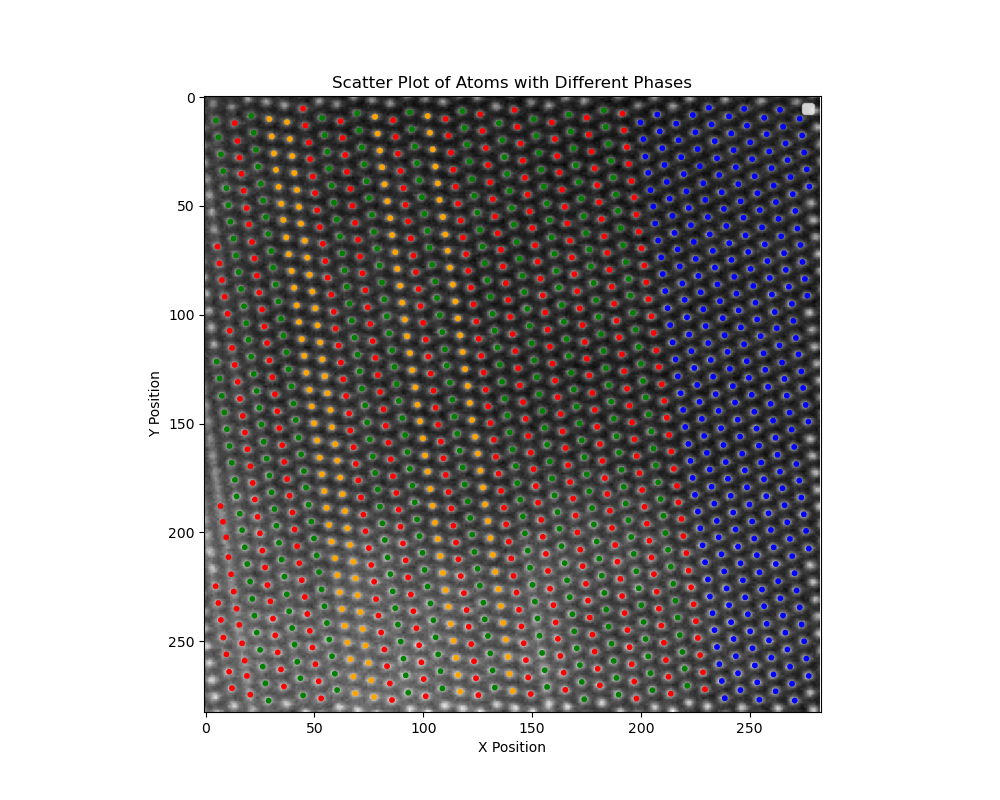

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_cpp['x_position'], df_cpp['y_position'], c=df_cpp['color'], s=10)
background_image = sublattice.image
ax.imshow(background_image, cmap='gray')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Scatter Plot of Atoms with Different Phases')
ax.legend()
plt.show()

In [23]:
full_path_res = f"{folder_path}\\color_result_{num_of_img}.xlsx"
full_path_seg = f"{folder_path}\\thickness_{num_of_img}.xlsx"
color_result_df.to_excel(full_path_res)
segment_info.to_excel(full_path_seg)

NameError: name 'folder_path' is not defined